# ProbCox
Example script accompyining "Probabilistic Cox regression via stochastic variational inference" to showcase a simple simulation for the high-dimensional case setting. 

First download and install the package probcox from pip:

In [1]:
!pip3 install probcox

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 614kB 8.2MB/s 
  Created wheel for probcox: filename=probcox-0.0.4-cp37-none-any.whl size=5309 sha256=45a15f789ee7ff45d158132b9f8f3d1af8594391a64efb5b29ed53338121261b
  Stored in directory: /root/.cache/pip/wheels/db/74/f7/717e5de377b51e3346d18f66822448db9b817849937ad72d8f
Successfully built probcox


Then we load some other python packages that we will be using along the way:

In [2]:
import tqdm
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import probcox as pcox

import warnings
warnings.filterwarnings("ignore") # stopping some warning messages - that clutter some of the output.

dtype = torch.FloatTensor # standard array type

# set seeds for replication
np.random.seed(19304)
torch.manual_seed(918331)

Now we simulate some example data that we use for inference later:


In [3]:
# define true parameter values
theta = np.random.normal(0, 0.75, 20)[:, None]
theta = np.concatenate((theta[:10], np.zeros((4990, 1)), theta[10:], np.zeros((4990, 1))))

# number and type of covariates
P_binary = 5000
P_continuous = 5000

(array([ 12.,  51.,  90., 178., 229., 197., 145.,  67.,  25.,   6.]),
 array([-5.83041394, -4.43496223, -3.03951052, -1.64405881, -0.2486071 ,
         1.14684461,  2.54229633,  3.93774804,  5.33319975,  6.72865146,
         8.12410317]),
 <a list of 10 Patch objects>)

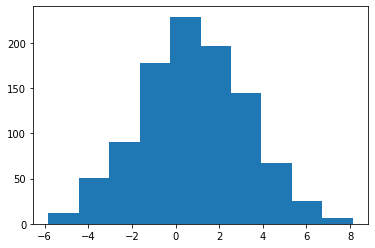

In [4]:
# rough distribution for the corresponding linear effect size
X = np.concatenate((np.random.binomial(1, 0.2, (1000, P_binary)), np.random.normal(0, 1, (1000, P_continuous))), axis=1)
plt.hist(np.matmul(X, theta))

In [5]:
# setup the class for simulkation 
TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

# define the baseline hazard - scale is set to achieve a rough level of censorship (increase for higher censorship)
TVC.make_lambda0(scale=2)
# gauge the number to desired level of censorship
print('\n Censorship: ', str(1 - (np.sum([torch.sum(TVC.sample()[0][:, -1]).numpy() for ii in tqdm.tqdm(range(1000))])/1000)))

100%|██████████| 1000/1000 [00:17<00:00, 57.97it/s]


 Censorship:  0.45199999999999996


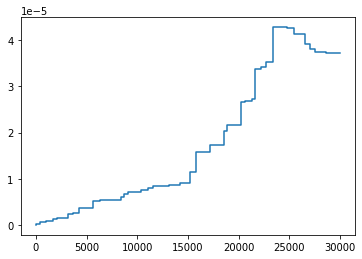

In [6]:
# Return the underlying shape of the baseline hazard and plot
t_l, ll = TVC.return_lambda0()
plt.step(t_l, ll)

In [7]:
# simulate data set
surv = torch.zeros((0, 3))
X = torch.zeros((0, theta.shape[0]))
for __ in tqdm.tqdm(range(1000)):
    a, b = TVC.sample()
    surv = torch.cat((surv, a))
    X = torch.cat((X, b))

100%|██████████| 1000/1000 [00:52<00:00, 19.22it/s]


In [8]:
print('Interval observation: ', str(surv.shape[0]))
print('Number of events: ', str(torch.sum(surv[:, -1] == 1).numpy().tolist()))

Interval observation:  5766
Number of events:  568


In [9]:
# Collect sample information for re-weigthing of likelihood
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, None, total_events, None]

After simulating the data we can run the probcox on the generated data:

In [10]:
# set desired level of batchsize
batchsize = 512

In [11]:
def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

In [12]:
# run inference
sampling_proportion[1] = batchsize
eta=10
run = True
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
    m.initialize(eta=eta, num_particles=5, rank=10)
    loss=[0]
    for ii in tqdm.tqdm(range((50000))):
        # random sub-sampling - define at least 2 events - otherwise thre is no effect on the loglikelihood.
        idx = np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 2, replace=False), np.random.choice(range(surv.shape[0]), batchsize-2, replace=False)))
        data=[surv[idx], X[idx]]
        loss.append(m.infer(data=data))
        # divergence check
        if loss[-1] != loss[-1]:
            eta = eta * 0.1
            run=True
            break   

100%|██████████| 50000/50000 [54:21<00:00, 15.33it/s]


In [15]:
# extract the parameter values and lower/upper bounds
g = m.return_guide()
out = g.quantiles([0.025, 0.5, 0.975])
print(out)

{'theta': [tensor([[ 0.8371],
        [-0.0040],
        [-0.0023],
        ...,
        [-0.0030],
        [-0.0040],
        [-0.0024]], grad_fn=<ViewBackward>), tensor([[ 1.0514e+00],
        [-4.5841e-04],
        [ 1.2706e-03],
        ...,
        [ 5.1605e-04],
        [-4.6785e-04],
        [ 1.1119e-03]], grad_fn=<ViewBackward>), tensor([[1.2657],
        [0.0031],
        [0.0048],
        ...,
        [0.0040],
        [0.0031],
        [0.0046]], grad_fn=<ViewBackward>)]}


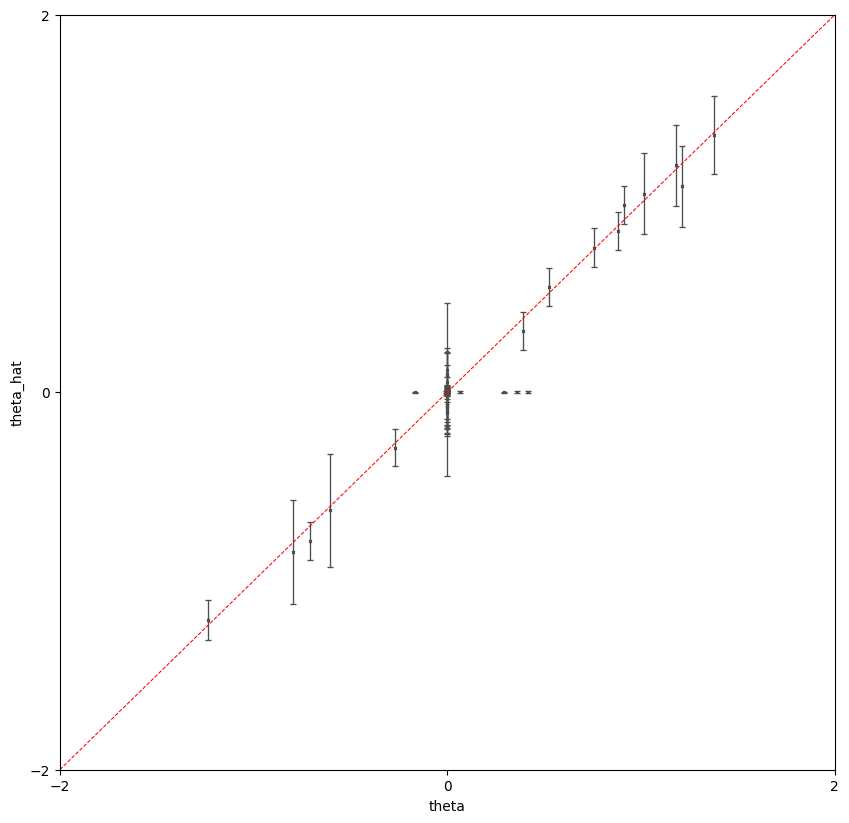

In [16]:
# plot the results
theta_est = out['theta'][1].detach().numpy()
theta_est_lower = out['theta'][0].detach().numpy()
theta_est_upper = out['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c=".3", capsize=2, capthick=0.95, elinewidth=0.95)
ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.show()
plt.close()


In [20]:
# number of significant parameters
np.sum(np.sign(theta_est_lower[:, 0]) == np.sign(theta_est_upper[:, 0]))

15

In [21]:
# true estimates of the significant paramters
theta[np.sign(theta_est_lower[:, 0]) == np.sign(theta_est_upper[:, 0])]

array([[ 1.01375336],
       [ 1.21374657],
       [-0.79555857],
       [-0.60598122],
       [ 1.1788807 ],
       [ 1.37480508],
       [ 0.91120968],
       [-1.23375844],
       [ 0.39038631],
       [ 0.88167961],
       [ 0.75480779],
       [-0.7077001 ],
       [ 0.52252855],
       [-0.26937659],
       [ 0.        ]])